# Assignment 2: Experiment Tracking

## 2. Model Version Control and Experiment Tracking

### Track Experiments and Model Versions using MLflow

In `train.ipynb`, track the experiments and model versions using **MLflow**:

1. **Build, track, and register 3 benchmark models** using MLflow.
2. Checkout and print the model selection metric **AUCPR** for each of the three benchmark models.

#### References for ML Experiment Tracking

- [MLflow Tracking Documentation](https://mlflow.org/docs/latest/tracking.html)
- [MLflow Quickstart Guide](https://mlflow.org/docs/latest/getting-started/intro-quickstart/index.html)
- [Tracking ML Experiments with MLflow](https://www.datarevenue.com/en-blog/how-we-track-machine-learning-experiments-with-mlflow)
- [Experiment Tracking with MLflow](https://towardsdatascience.com/experiment-tracking-with-mlflow-in-10-minutes-f7c2128b8f2c)
- [MadeWithML - Experiment Tracking](https://madewithml.com/courses/mlops/experiment-tracking/)

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score,roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')

In [77]:
train_data = pd.read_csv("./train.csv")
val_data = pd.read_csv("./val.csv")
test_data = pd.read_csv("./test.csv")

In [78]:
print(train_data.isnull().sum(), val_data.isnull().sum(), test_data.isnull().sum())

message    3
label      0
dtype: int64 message    3
label      0
dtype: int64 message    0
label      0
dtype: int64


In [79]:
# Drop rows with NaNs in any column
train_data = train_data.dropna()
val_data = val_data.dropna()
test_data = test_data.dropna()

X_train, y_train = train_data.drop(columns="label"), train_data["label"].values
X_val, y_val = val_data.drop(columns="label"), val_data["label"].values
X_test, y_test = test_data.drop(columns="label"), test_data["label"].values

### vectorize data

In [80]:
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the training data
X_train = vectorizer.fit_transform(X_train['message'])

# Transform the validation and test data
X_val = vectorizer.transform(X_val['message'])
X_test = vectorizer.transform(X_test['message'])

### Logistic Regression

In [81]:
# Logistic Regression
lr_model = LogisticRegression()
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Hyperparameter tuning with GridSearchCV   
lr_search = GridSearchCV(lr_model, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lr_search.fit(X_train, y_train)
best_lr_model = lr_search.best_estimator_
print(f"\nBest Logistic Regression Params: {lr_search.best_params_}")
print(f"Validation Accuracy (Logistic Regression): {accuracy_score(y_val, best_lr_model.predict(X_val)):.4f}")

# Classification report 
y_test_pred_lr = best_lr_model.predict(X_test)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_test_pred_lr))

# AUC ROC score 
y_test_prob_lr = best_lr_model.predict_proba(X_test)[:, 1]
roc_auc_lr = roc_auc_score(y_test, y_test_prob_lr, multi_class='ovr')
print(f"AUC ROC Score (Logistic Regression): {roc_auc_lr:.4f}")


Best Logistic Regression Params: {'C': 10, 'penalty': 'l2'}
Validation Accuracy (Logistic Regression): 0.9865

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       966
           1       0.96      0.87      0.91       149

    accuracy                           0.98      1115
   macro avg       0.97      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115

AUC ROC Score (Logistic Regression): 0.9828


### Support Vector Classifer (SVC)

In [82]:
svc_model = SVC(probability=True)
svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Hyperparameter tuning with GridSearchCV
svc_search = GridSearchCV(svc_model, svc_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svc_search.fit(X_train, y_train)
best_svc_model = svc_search.best_estimator_
print(f"\nBest SVC Params: {svc_search.best_params_}")
print(f"Validation Accuracy (SVC): {accuracy_score(y_val, best_svc_model.predict(X_val)):.4f}")

# Classification report
y_test_pred_svc = best_svc_model.predict(X_test)
print("\nSVC Classification Report:")
print(classification_report(y_test, y_test_pred_svc))

# AUC ROC score for SVC
y_test_prob_svc = best_svc_model.predict_proba(X_test)[:, 1]
roc_auc_svc = roc_auc_score(y_test, y_test_prob_svc)
print(f"AUC ROC Score (SVC): {roc_auc_svc:.4f}")



Best SVC Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Validation Accuracy (SVC): 0.9842

SVC Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       966
           1       0.96      0.89      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

AUC ROC Score (SVC): 0.9810


### Random Forest

In [83]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Hyperparameter tuning with GridSearchCV
rf_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf_model = rf_search.best_estimator_
print(f"\nBest Random Forest Params: {rf_search.best_params_}")
print(f"Validation Accuracy (Random Forest): {accuracy_score(y_val, best_rf_model.predict(X_val)):.4f}")

# Classification report
y_test_pred_rf = best_rf_model.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_test_pred_rf))

# AUC ROC score
y_test_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_test_prob_rf, multi_class='ovr')
print(f"AUC ROC Score (Random Forest): {roc_auc_rf:.4f}")



Best Random Forest Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Validation Accuracy (Random Forest): 0.9797

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.97      0.83      0.89       149

    accuracy                           0.97      1115
   macro avg       0.97      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115

AUC ROC Score (Random Forest): 0.9826


### Naive Bayes

In [84]:
# Naive Bayes
nb_model = MultinomialNB()
nb_param_grid = {'alpha': [0.1, 0.5, 1.0]}

# Hyperparameter tuning with GridSearchCV
nb_search = GridSearchCV(nb_model, nb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

nb_search.fit(X_train, y_train)
best_nb_model = nb_search.best_estimator_
print(f"\nBest Naive Bayes Params: {nb_search.best_params_}")
print(f"Validation Accuracy (Naive Bayes): {accuracy_score(y_val, best_nb_model.predict(X_val)):.4f}")

# Classification report
y_test_pred_nb = best_nb_model.predict(X_test)
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, y_test_pred_nb))

# AUC ROC score
y_test_prob_nb = best_nb_model.predict_proba(X_test)[:, 1] 
roc_auc_nb = roc_auc_score(y_test, y_test_prob_nb)
print(f"AUC ROC Score (Naive Bayes): {roc_auc_nb:.4f}")


Best Naive Bayes Params: {'alpha': 0.5}
Validation Accuracy (Naive Bayes): 0.9752

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       0.99      0.82      0.90       149

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115

AUC ROC Score (Naive Bayes): 0.9820


### Comparing models

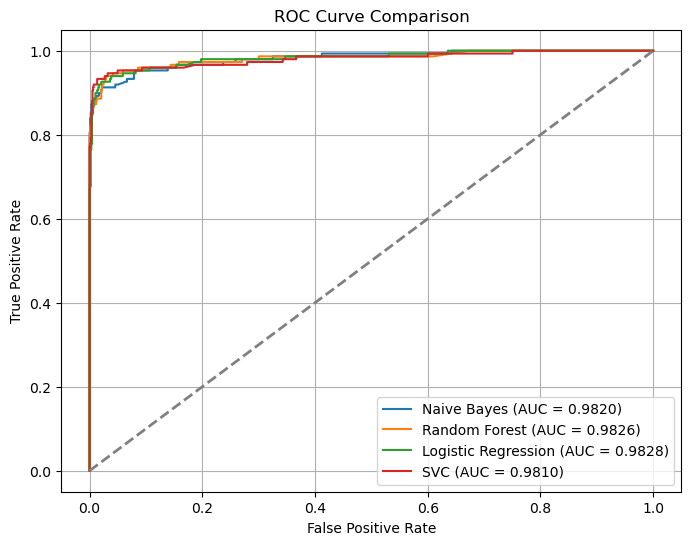

In [85]:
model_auc_scores = {}

models = {
    "Naive Bayes": best_nb_model,
    "Random Forest": best_rf_model,
    "Logistic Regression": best_lr_model,
    "SVC": best_svc_model
}

plt.figure(figsize=(8, 6))

for model_name, model in models.items():
    y_test_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)
    model_auc_scores[model_name] = roc_auc
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

In [86]:
sorted_models = sorted(model_auc_scores.items(), key=lambda x: x[1], reverse=True)

print("\nRanked Models by AUC ROC Score:")
for rank, (model_name, auc_score) in enumerate(sorted_models, start=1):
    print(f"{rank}. {model_name}: {auc_score:.4f}")


Ranked Models by AUC ROC Score:
1. Logistic Regression: 0.9828
2. Random Forest: 0.9826
3. Naive Bayes: 0.9820
4. SVC: 0.9810
